In [264]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io
import random
from collections import defaultdict
import math
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model, decomposition
from sklearn.metrics import precision_score, recall_score
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from os import listdir
import pickle

In [2]:
pairwise_WDAn_X = np.load('pairwise_WDAn_X.npy')
pairwise_WDAn_y = np.load('pairwise_WDAn_y.npy')

### With very high likelihood there will be at least one of each bacteria in the test, so we good

In [3]:
total_size = len(pairwise_WDAn_X)
train_size = int(total_size*0.95)

tr = random.sample(list(range(total_size)),train_size)
te = sorted(list(set(range(total_size)).difference(set(tr))))

### Baseline 1: get one-hot vectors of reactions for two bacteria, and feed into linear regression
- cannot generalize to unseen reactions
- regularization is essential, otherwise extreme overfitting occurs
- average guess within 0.26 of actual value

In [4]:
train_x = pairwise_WDAn_X[tr][:20000]
train_y = pairwise_WDAn_y[tr][:20000]
test_x = pairwise_WDAn_X[te][:1000]
test_y = pairwise_WDAn_y[te][:1000]

In [90]:
lr = linear_model.Ridge()

lr.fit(train_x,train_y)
print('Linear Regression Training MSE: '+str(sklearn.metrics.mean_squared_error(lr.predict(train_x),train_y)))

Linear Regression Training MSE: 0.05513384599363458


In [91]:
print(np.mean(lr.coef_))
np.std(lr.coef_)

0.00013055720150947014


0.04899349160185669

In [92]:
test_preds = lr.predict(test_x)

print('Linear Regression Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,test_y)))

Linear Regression Test MSE: 0.06964001534507036


### Baseline 2: get indicator vectors of reactions for two bacteria, and feed into simple neural network

In [5]:
train_x = pairwise_WDAn_X[tr][:10000]
train_y = pairwise_WDAn_y[tr][:10000]

### Grid Search Hyperparameters

In [7]:
alphas = [1e-4,1e-3,1e-2,1e-1,0,1,10]
lrs = [1e-5,1e-4,1e-3,1e-2]

for alpha in alphas:
    for lr in lrs:
        
        print('Weight Decay: '+str(alpha)+', Learning Rate: '+str(lr))
        BasicNN = nn.Sequential(
            nn.Linear(len(pairwise_WDAn_X[0]),512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128,1)
        )

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(BasicNN.parameters(),lr=lr,weight_decay=alpha)

        epochs = 5
        
        for i in range(epochs):
            curr_loss = 0
            for k in range(len(train_x)):
                X = torch.Tensor(train_x[k])
                y = torch.Tensor([train_y[k]])

                optimizer.zero_grad()

                output = BasicNN(X)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

                curr_loss += loss.item()

            print('Epoch '+str(i)+', Train MSE: '+ str(curr_loss/len(train_x)))

            with torch.no_grad():
                test_preds = np.transpose(BasicNN(torch.Tensor(test_x)))[0]
                print('Neural Net Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,test_y)))
        


Weight Decay: 0.0001, Learning Rate: 1e-05
Epoch 0, Train MSE: 0.08821307470804834
Neural Net Test MSE: 0.08312078418919858
Epoch 1, Train MSE: 0.08101959077669607
Neural Net Test MSE: 0.07619718633275235
Epoch 2, Train MSE: 0.07758341257742324
Neural Net Test MSE: 0.07383445137453493
Epoch 3, Train MSE: 0.07469824921461435
Neural Net Test MSE: 0.07087489504138626
Epoch 4, Train MSE: 0.07232484356153039
Neural Net Test MSE: 0.07094009229785177
Weight Decay: 0.0001, Learning Rate: 0.0001
Epoch 0, Train MSE: 0.08837124838376768
Neural Net Test MSE: 0.08141207744247657
Epoch 1, Train MSE: 0.08091533468408768
Neural Net Test MSE: 0.07660719803429995
Epoch 2, Train MSE: 0.0775847975091848
Neural Net Test MSE: 0.07341995194317204
Epoch 3, Train MSE: 0.07468848253748875
Neural Net Test MSE: 0.07031628944496039
Epoch 4, Train MSE: 0.07225403567564187
Neural Net Test MSE: 0.06893277405625967
Weight Decay: 0.0001, Learning Rate: 0.001
Epoch 0, Train MSE: 0.09364854140883436
Neural Net Test MSE: 

### Alpha, LR = (1e-4,1e-4) or (0,1e-5)

In [8]:
BasicNN = nn.Sequential(
    nn.Linear(len(pairwise_WDAn_X[0]),512),
    nn.ReLU(),
    nn.Linear(512,128),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(128,1)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(BasicNN.parameters(),lr=1e-4,weight_decay=1e-4)

epochs = 20

In [9]:
for i in range(epochs):
    curr_loss = 0
    for k in range(len(train_x)):
        X = torch.Tensor(train_x[k])
        y = torch.Tensor([train_y[k]])
        
        optimizer.zero_grad()
        
        output = BasicNN(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        curr_loss += loss.item()
        
    print('Epoch '+str(i)+', Train MSE: '+ str(curr_loss/len(train_x)))
        
    with torch.no_grad():
        test_preds = np.transpose(BasicNN(torch.Tensor(test_x)))[0]
        print('Neural Net Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,test_y)))

Epoch 0, Train MSE: 0.08983937128204726
Neural Net Test MSE: 0.08375771355461349
Epoch 1, Train MSE: 0.0813425854141002
Neural Net Test MSE: 0.07750277160507042
Epoch 2, Train MSE: 0.07797892654698683
Neural Net Test MSE: 0.07161010515420482
Epoch 3, Train MSE: 0.07521553447005085
Neural Net Test MSE: 0.07126278810782449
Epoch 4, Train MSE: 0.07303566736887897
Neural Net Test MSE: 0.06989680566097316
Epoch 5, Train MSE: 0.0707476293446527
Neural Net Test MSE: 0.06842710624385115
Epoch 6, Train MSE: 0.0692623049965984
Neural Net Test MSE: 0.06721430529910544
Epoch 7, Train MSE: 0.0682621368587001
Neural Net Test MSE: 0.06635145053662773
Epoch 8, Train MSE: 0.06706365980311792
Neural Net Test MSE: 0.06565245704623725
Epoch 9, Train MSE: 0.06542091053556888
Neural Net Test MSE: 0.06461590542971786
Epoch 10, Train MSE: 0.06410630606881733
Neural Net Test MSE: 0.06403482722255388
Epoch 11, Train MSE: 0.06354074662001387
Neural Net Test MSE: 0.06523352141275617
Epoch 12, Train MSE: 0.0625106

## Normalized Growth Ratio Pair Prediction

In [296]:
bac_rxn_ind = pickle.load( open( "Generated_Data/bac_rxn_ind.pickle", "rb" ) )
bac_met_ind = pickle.load( open( "Generated_Data/bac_met_ind.pickle", "rb" ) )

In [297]:
p_n_g = pd.read_csv('Generated_Data/pairwise_w_growth.csv')

In [298]:
p_n_g = p_n_g.drop('Unnamed: 0',axis=1)

Augment data by switching places

In [299]:
# columns = ['Strain2','Strain1','MetabolicDistance','WesternDietAnaerobic_Strain2','WesternDietAnaerobic_Strain1',
#           'WesternDietAerobic_Strain2','WesternDietAerobic_Strain1','HighFiberDietAnaerobic_Strain2',
#            'HighFiberDietAnaerobic_Strain1','HighFiberDietAerobic_Strain2','HighFiberDietAerobic_Strain1',
#           'S6 WD An 2','S6 WD An 1','S6 WD Ae 2','S6 WD Ae 1','S6 HFD An 2','S6 HFD An 1','S6 HFD Ae 2','S6 HFD Ae 1']
p_n_g_reversed = p_n_g.copy()

p_n_g_reversed['Strain1'] = p_n_g['Strain2']
p_n_g_reversed['Strain2'] = p_n_g['Strain1']

p_n_g_reversed['WesternDietAnaerobic_Strain1'] = p_n_g['WesternDietAnaerobic_Strain2']
p_n_g_reversed['WesternDietAnaerobic_Strain2'] = p_n_g['WesternDietAnaerobic_Strain1']
p_n_g_reversed['WesternDietAerobic_Strain1'] = p_n_g['WesternDietAerobic_Strain2']
p_n_g_reversed['WesternDietAerobic_Strain2'] = p_n_g['WesternDietAerobic_Strain1']
p_n_g_reversed['HighFiberDietAnaerobic_Strain1'] = p_n_g['HighFiberDietAnaerobic_Strain2']
p_n_g_reversed['HighFiberDietAnaerobic_Strain2'] = p_n_g['HighFiberDietAnaerobic_Strain1']
p_n_g_reversed['HighFiberDietAerobic_Strain1'] = p_n_g['HighFiberDietAerobic_Strain2']
p_n_g_reversed['HighFiberDietAerobic_Strain2'] = p_n_g['HighFiberDietAerobic_Strain1']

p_n_g_reversed['S6 WD An 1'] = p_n_g['S6 WD An 2']
p_n_g_reversed['S6 WD An 2'] = p_n_g['S6 WD An 1']
p_n_g_reversed['S6 WD Ae 1'] = p_n_g['S6 WD Ae 2']
p_n_g_reversed['S6 WD Ae 2'] = p_n_g['S6 WD Ae 1']
p_n_g_reversed['S6 HFD An 1'] = p_n_g['S6 HFD An 2']
p_n_g_reversed['S6 HFD An 2'] = p_n_g['S6 HFD An 1']
p_n_g_reversed['S6 HFD Ae 1'] = p_n_g['S6 HFD Ae 2']
p_n_g_reversed['S6 HFD Ae 2'] = p_n_g['S6 HFD Ae 1']

p_n_g_reversed.tail()

,Strain1,Strain2,MetabolicDistance,WesternDietAnaerobic_Strain1,WesternDietAnaerobic_Strain2,WesternDietAerobic_Strain1,WesternDietAerobic_Strain2,HighFiberDietAnaerobic_Strain1,HighFiberDietAnaerobic_Strain2,HighFiberDietAerobic_Strain1,HighFiberDietAerobic_Strain2,S6 WD An 1,S6 WD An 2,S6 WD Ae 1,S6 WD Ae 2,S6 HFD An 1,S6 HFD An 2,S6 HFD Ae 1,S6 HFD Ae 2
298373,Yersinia_rohdei_ATCC_43380,Yersinia_kristensenii_ATCC_33638,0.073990,0.215689,0.241949,0.221143,0.236495,0.110383,0.118436,0.111619,0.117200,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819
298374,Yokenella_regensburgei_ATCC_43003,Yersinia_kristensenii_ATCC_33638,0.164637,0.240174,0.217464,0.248677,0.208962,0.122666,0.106153,0.125371,0.103448,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819
298375,Yersinia_rohdei_ATCC_43380,Yersinia_pseudotuberculosis_YPIII,0.123241,0.278240,0.179399,0.258750,0.198889,0.137034,0.091785,0.128764,0.100055,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819
298376,Yokenella_regensburgei_ATCC_43003,Yersinia_pseudotuberculosis_YPIII,0.172193,0.282532,0.175107,0.271263,0.186376,0.142342,0.086477,0.137148,0.091671,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819
298377,Yokenella_regensburgei_ATCC_43003,Yersinia_rohdei_ATCC_43380,0.137244,0.252982,0.204657,0.258087,0.199552,0.126369,0.102450,0.128426,0.100393,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819


In [300]:
p_n_g_duplicated = p_n_g.append(p_n_g_reversed,ignore_index=True)

In [301]:
p_n_g_duplicated.tail()

,Strain1,Strain2,MetabolicDistance,WesternDietAnaerobic_Strain1,WesternDietAnaerobic_Strain2,WesternDietAerobic_Strain1,WesternDietAerobic_Strain2,HighFiberDietAnaerobic_Strain1,HighFiberDietAnaerobic_Strain2,HighFiberDietAerobic_Strain1,HighFiberDietAerobic_Strain2,S6 WD An 1,S6 WD An 2,S6 WD Ae 1,S6 WD Ae 2,S6 HFD An 1,S6 HFD An 2,S6 HFD Ae 1,S6 HFD Ae 2
596751,Yersinia_rohdei_ATCC_43380,Yersinia_kristensenii_ATCC_33638,0.073990,0.215689,0.241949,0.221143,0.236495,0.110383,0.118436,0.111619,0.117200,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819
596752,Yokenella_regensburgei_ATCC_43003,Yersinia_kristensenii_ATCC_33638,0.164637,0.240174,0.217464,0.248677,0.208962,0.122666,0.106153,0.125371,0.103448,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819
596753,Yersinia_rohdei_ATCC_43380,Yersinia_pseudotuberculosis_YPIII,0.123241,0.278240,0.179399,0.258750,0.198889,0.137034,0.091785,0.128764,0.100055,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819
596754,Yokenella_regensburgei_ATCC_43003,Yersinia_pseudotuberculosis_YPIII,0.172193,0.282532,0.175107,0.271263,0.186376,0.142342,0.086477,0.137148,0.091671,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819
596755,Yokenella_regensburgei_ATCC_43003,Yersinia_rohdei_ATCC_43380,0.137244,0.252982,0.204657,0.258087,0.199552,0.126369,0.102450,0.128426,0.100393,0.457639,0.457639,0.457639,0.457639,0.228819,0.228819,0.228819,0.228819


## Reaction Indicator Vectors (Western - Aerobic)


In [302]:
total_size = len(p_n_g_duplicated)
train_size = 10000
val_size = 1000
test_size = 1000

tr = sorted(random.sample(list(range(total_size)),train_size))
val_n_te = set(range(total_size)).difference(set(tr))
val = sorted(list(random.sample(val_n_te,val_size)))
te = sorted(random.sample(val_n_te.difference(set(val)), test_size))

In [395]:
x_train = []
y_train = []
for i,row in p_n_g_duplicated.iloc[tr].iterrows():
    id1 = row['Strain1']
    id2 = row['Strain2']
    if 'Roseburia_hominis_A2_183' in [id1,id2] or id1 not in bac_rxn_ind or id2 not in bac_rxn_ind:
        continue
    
    b1 = list(bac_rxn_ind[id1])
    b2 = list(bac_rxn_ind[id2])
    x_train.append(b1+b2)
    y_train.append(
        np.log([row['WesternDietAerobic_Strain1']/row['S6 WD Ae 1'],row['WesternDietAerobic_Strain2']/row['S6 WD Ae 2']]))

In [396]:
x_val = []
y_val = []
for i,row in p_n_g_duplicated.iloc[val].iterrows():
    id1 = row['Strain1']
    id2 = row['Strain2']
    if 'Roseburia_hominis_A2_183' in [id1,id2] or id1 not in bac_rxn_ind or id2 not in bac_rxn_ind:
        continue
    
    b1 = list(bac_rxn_ind[id1])
    b2 = list(bac_rxn_ind[id2])
    x_val.append(b1+b2)
    y_val.append(
        np.log([row['WesternDietAerobic_Strain1']/row['S6 WD Ae 1'],row['WesternDietAerobic_Strain2']/row['S6 WD Ae 2']]))

In [397]:
x_test = []
y_test = []
for i,row in p_n_g_duplicated.iloc[te].iterrows():
    id1 = row['Strain1']
    id2 = row['Strain2']
    if 'Roseburia_hominis_A2_183' in [id1,id2] or id1 not in bac_rxn_ind or id2 not in bac_rxn_ind:
        continue
    
    b1 = list(bac_rxn_ind[id1])
    b2 = list(bac_rxn_ind[id2])
    x_test.append(b1+b2)
    y_test.append(
        np.log([row['WesternDietAerobic_Strain1']/row['S6 WD Ae 1'],row['WesternDietAerobic_Strain2']/row['S6 WD Ae 2']]))

Text(0.5, 1.0, 'Histogram of Growth Ratios in Training Set')

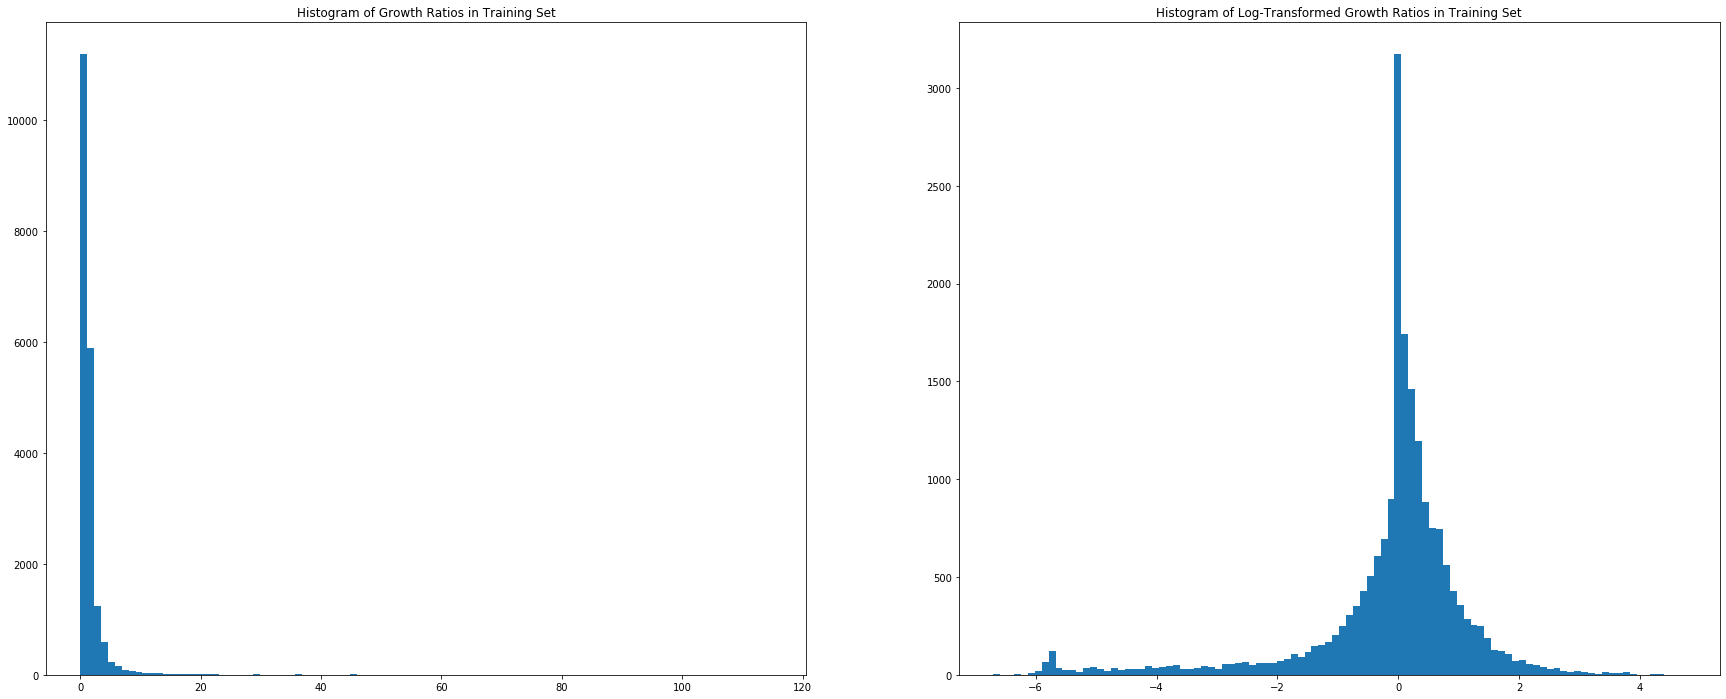

In [306]:
_, axes = plt.subplots(1,2,figsize=(30,12))

axes[1].hist(np.array(y_train).flatten(),bins=100)
axes[1].set_title('Histogram of Log-Transformed Growth Ratios in Training Set')
axes[0].hist(np.exp(np.array(y_train).flatten()),bins=100)
axes[0].set_title('Histogram of Growth Ratios in Training Set')

Ridge

In [322]:
lr = linear_model.Ridge(alpha=1)

In [323]:
lr.fit(x_train,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [324]:
print('Ridge Regression Training MSE: '+str(sklearn.metrics.mean_squared_error(lr.predict(x_train),y_train)))

Ridge Regression Training MSE: 1.1351006533958534


In [325]:
print(np.mean(lr.coef_))
np.std(lr.coef_)

0.00011286690051948105


0.038821759993154764

In [326]:
val_preds = lr.predict(x_val)

print('Ridge Regression Val MSE: '+str(sklearn.metrics.mean_squared_error(val_preds,y_val)))

Ridge Regression Val MSE: 1.6117770212462386


In [327]:
test_preds = lr.predict(x_test)

print('Ridge Regression Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

Ridge Regression Test MSE: 1.6996638719646429


LASSO

In [338]:
lr = linear_model.Lasso(alpha=0.01)

In [339]:
lr.fit(x_train,y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [340]:
print('LASSO Regression Training MSE: '+str(sklearn.metrics.mean_squared_error(lr.predict(x_train),y_train)))

LASSO Regression Training MSE: 1.4749885664092748


In [341]:
print(np.mean(lr.coef_))
np.std(lr.coef_)

-5.8546865625523936e-05


0.006833623651233635

In [342]:
val_preds = lr.predict(x_val)

print('LASSO Regression Val MSE: '+str(sklearn.metrics.mean_squared_error(val_preds,y_val)))

LASSO Regression Val MSE: 1.519894270532873


In [343]:
test_preds = lr.predict(x_test)

print('LASSO Regression Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

LASSO Regression Test MSE: 1.689871029409478


Neural Net

In [258]:
BasicNN = nn.Sequential(
    nn.Linear(len(x_train[0]),1024),
    nn.ReLU(),
    nn.Linear(1024,1024),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(1024,512),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(512,128),
    nn.ReLU(),
    nn.Linear(128,2),
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(BasicNN.parameters(),lr=1e-4,weight_decay=1e-4)

epochs = 10

In [259]:
for i in range(epochs):
    for k in range(len(x_train)):
        if k % 1000 == 1:
            print(str(k/len(x_train)*100)+'% completed')
            with torch.no_grad():
                train_preds = BasicNN(torch.Tensor(x_train))
                print('Neural Net Train MSE: '+str(sklearn.metrics.mean_squared_error(train_preds,y_train)))
                val_preds = BasicNN(torch.Tensor(x_val))
                print('Neural Net Val MSE: '+str(sklearn.metrics.mean_squared_error(val_preds,y_val)))
        X = torch.Tensor(x_train[k])
        y = torch.Tensor(y_train[k])
        
        optimizer.zero_grad()
        
        output = BasicNN(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        

0.005065599513702447% completed
Neural Net Train MSE: 1.787869061789001
Neural Net Val MSE: 1.8278218044130767
5.070665113216148% completed
Neural Net Train MSE: 1.77455035894519
Neural Net Val MSE: 1.8084966991834532
10.136264626918596% completed
Neural Net Train MSE: 1.76499312449765
Neural Net Val MSE: 1.8037501764528705
15.201864140621044% completed
Neural Net Train MSE: 1.788315453468908
Neural Net Val MSE: 1.8370339728706613
20.26746365432349% completed
Neural Net Train MSE: 1.788607291815153
Neural Net Val MSE: 1.8291694128156852
25.333063168025937% completed
Neural Net Train MSE: 1.7852212497845472
Neural Net Val MSE: 1.8178953312262225
30.398662681728382% completed
Neural Net Train MSE: 1.8407290833638328
Neural Net Val MSE: 1.856471457227395
35.46426219543083% completed
Neural Net Train MSE: 1.8485666878754166
Neural Net Val MSE: 1.864044654623348
40.52986170913327% completed
Neural Net Train MSE: 1.7633288793286501
Neural Net Val MSE: 1.7705689171468753
45.59546122283572% co

KeyboardInterrupt: 

## PCA

In [260]:
# total_size = len(p_n_g_duplicated)
# train_size = 10000
# val_size = 2000
# test_size = 2000

# tr = sorted(random.sample(list(range(total_size)),train_size))
# val_n_te = set(range(total_size)).difference(set(tr))
# val = sorted(list(random.sample(val_n_te,val_size)))
# te = sorted(random.sample(val_n_te.difference(set(val)), test_size))

In [261]:
# x_train = []
# y_train = []
# for i,row in p_n_g_duplicated.iloc[tr].iterrows():
#     id1 = row['Strain1']
#     id2 = row['Strain2']
#     if 'Roseburia_hominis_A2_183' in [id1,id2] or id1 not in bac_rxn_ind or id2 not in bac_rxn_ind:
#         continue
    
#     b1 = list(bac_rxn_ind[id1])
#     b2 = list(bac_rxn_ind[id2])
#     x_train.append(b1+b2)
#     y_train.append(
#         np.log([row['WesternDietAerobic_Strain1']/row['S6 WD Ae 1'],row['WesternDietAerobic_Strain2']/row['S6 WD Ae 2']]))

In [262]:
# x_val = []
# y_val = []
# for i,row in p_n_g_duplicated.iloc[val].iterrows():
#     id1 = row['Strain1']
#     id2 = row['Strain2']
#     if 'Roseburia_hominis_A2_183' in [id1,id2] or id1 not in bac_rxn_ind or id2 not in bac_rxn_ind:
#         continue
    
#     b1 = list(bac_rxn_ind[id1])
#     b2 = list(bac_rxn_ind[id2])
#     x_val.append(b1+b2)
#     y_val.append(
#         np.log([row['WesternDietAerobic_Strain1']/row['S6 WD Ae 1'],row['WesternDietAerobic_Strain2']/row['S6 WD Ae 2']]))

In [263]:
# x_test = []
# y_test = []
# for i,row in p_n_g_duplicated.iloc[te].iterrows():
#     id1 = row['Strain1']
#     id2 = row['Strain2']
#     if 'Roseburia_hominis_A2_183' in [id1,id2] or id1 not in bac_rxn_ind or id2 not in bac_rxn_ind:
#         continue
    
#     b1 = list(bac_rxn_ind[id1])
#     b2 = list(bac_rxn_ind[id2])
#     x_test.append(b1+b2)
#     y_test.append(
#         np.log([row['WesternDietAerobic_Strain1']/row['S6 WD Ae 1'],row['WesternDietAerobic_Strain2']/row['S6 WD Ae 2']]))

In [398]:
pca = decomposition.PCA(128)

In [399]:
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=128, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [400]:
sum(pca.explained_variance_ratio_)

0.8065390284517037

In [401]:
x_train_pca = pca.transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

In [402]:
x_train_pca.shape

(9880, 128)

Linear Regression

In [403]:
lr = linear_model.LinearRegression()

In [404]:
lr.fit(x_train_pca,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [405]:
print('PCA Linear Regression Training MSE: '+str(sklearn.metrics.mean_squared_error(lr.predict(x_train_pca),y_train)))

PCA Linear Regression Training MSE: 1.5337551793884767


In [406]:
print(np.mean(lr.coef_))
np.std(lr.coef_)

0.00021202285201654398


0.025115159817673836

In [407]:
test_preds = lr.predict(x_test_pca)

print('PCA Linear Regression Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

PCA Linear Regression Test MSE: 1.7121068912916906


Ridge

In [408]:
lr = linear_model.Ridge()

In [409]:
lr.fit(x_train_pca,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [410]:
print('Ridge Regression Training MSE: '+str(sklearn.metrics.mean_squared_error(lr.predict(x_train_pca),y_train)))

Ridge Regression Training MSE: 1.533755179796823


In [411]:
print(np.mean(lr.coef_))
np.std(lr.coef_)

0.00021201883399874725


0.025113904771418206

In [412]:
test_preds = lr.predict(x_test_pca)

print('Ridge Regression Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

Ridge Regression Test MSE: 1.7121054247584042


LASSO

In [413]:
lr = linear_model.Lasso(alpha=0.01)

In [414]:
lr.fit(x_train_pca,y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [415]:
print('Lasso Regression Training MSE: '+str(sklearn.metrics.mean_squared_error(lr.predict(x_train_pca),y_train)))

Lasso Regression Training MSE: 1.5389309819860326


In [416]:
print(np.mean(lr.coef_))
np.std(lr.coef_)

1.216202600009438e-05


0.02147347122374245

In [417]:
test_preds = lr.predict(x_test_pca)

print('Lasso Regression Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

Lasso Regression Test MSE: 1.7133011611249698


Neural Net

In [432]:
BasicNN = nn.Sequential(
    nn.Linear(len(x_train_pca[0]),256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,64),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(64,2),
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(BasicNN.parameters(),lr=1e-4,weight_decay=1e-4)

epochs = 5

In [433]:
for i in range(epochs):
    print('Epoch '+str(i+1))
    for k in range(len(x_train_pca)):
        X = torch.Tensor(x_train_pca[k])
        y = torch.Tensor(y_train[k])
        
        optimizer.zero_grad()
        
        output = BasicNN(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        train_preds = BasicNN(torch.Tensor(x_train_pca))
        print('Neural Net Train MSE: '+str(sklearn.metrics.mean_squared_error(train_preds,y_train)))
        val_preds = BasicNN(torch.Tensor(x_val_pca))
        print('Neural Net Val MSE: '+str(sklearn.metrics.mean_squared_error(val_preds,y_val)))
        

Epoch 1
Neural Net Train MSE: 1.3440783916417542
Neural Net Val MSE: 1.4572615664724737
Epoch 2
Neural Net Train MSE: 1.118700315219181
Neural Net Val MSE: 1.3439731189117126
Epoch 3
Neural Net Train MSE: 0.9725039066569579
Neural Net Val MSE: 1.281354482158991
Epoch 4
Neural Net Train MSE: 0.8755679198557271
Neural Net Val MSE: 1.2772647203469216
Epoch 5
Neural Net Train MSE: 0.7833297749868979
Neural Net Val MSE: 1.2219557287346685


In [434]:
with torch.no_grad():
    test_preds = BasicNN(torch.Tensor(x_test_pca))
    print('Neural Net Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

Neural Net Test MSE: 1.3095248936213726


## Embeddings

In [474]:
reaction_dict_by_ind = pickle.load(open('Generated_Data/reaction_dict_by_ind.pickle','rb'))
metabolite_dict_by_ind = pickle.load(open('Generated_Data/metabolite_dict_by_ind.pickle','rb'))

In [475]:
len(reaction_dict_by_ind)+len(metabolite_dict_by_ind)

7890

In [476]:
all_bacs = pickle.load(open('Generated_Data/all_bacs.pickle','rb'))

In [477]:
embeddings = {}

with open('Generated_Data/embeddings.txt','r') as file:
    for line in file:
        node = int(line.split()[0])
        vec = np.array(line.split()[1:]).astype(np.float64)
        
        if node in reaction_dict_by_ind:
            embeddings[reaction_dict_by_ind[node]] = vec
        else:
            embeddings[metabolite_dict_by_ind[node]] = vec

In [478]:
len(embeddings)

7450

In [479]:
bac_embeddings = {}

In [480]:
for bac,data in all_bacs.items():
    emb = np.zeros(128)
    for rxn in data[0]:
        if rxn in embeddings:
            emb += embeddings[rxn]
    for met in data[1]:
        emb += embeddings[met]
    bac_embeddings[bac] = emb

In [481]:
x_train = []
y_train = []
for i,row in p_n_g_duplicated.iloc[tr].iterrows():
    id1 = row['Strain1']
    id2 = row['Strain2']
    if 'Roseburia_hominis_A2_183' in [id1,id2] or id1 not in bac_rxn_ind or id2 not in bac_rxn_ind:
        continue
    
    b1 = list(bac_embeddings[id1])
    b2 = list(bac_embeddings[id2])
    x_train.append(b1+b2)
    y_train.append(
        np.log([row['WesternDietAerobic_Strain1']/row['S6 WD Ae 1'],row['WesternDietAerobic_Strain2']/row['S6 WD Ae 2']]))

In [482]:
x_val = []
y_val = []
for i,row in p_n_g_duplicated.iloc[val].iterrows():
    id1 = row['Strain1']
    id2 = row['Strain2']
    if 'Roseburia_hominis_A2_183' in [id1,id2] or id1 not in bac_rxn_ind or id2 not in bac_rxn_ind:
        continue
    
    b1 = list(bac_embeddings[id1])
    b2 = list(bac_embeddings[id2])
    x_val.append(b1+b2)
    y_val.append(
        np.log([row['WesternDietAerobic_Strain1']/row['S6 WD Ae 1'],row['WesternDietAerobic_Strain2']/row['S6 WD Ae 2']]))

In [483]:
x_test = []
y_test = []
for i,row in p_n_g_duplicated.iloc[te].iterrows():
    id1 = row['Strain1']
    id2 = row['Strain2']
    if 'Roseburia_hominis_A2_183' in [id1,id2] or id1 not in bac_rxn_ind or id2 not in bac_rxn_ind:
        continue
    
    b1 = list(bac_embeddings[id1])
    b2 = list(bac_embeddings[id2])
    x_test.append(b1+b2)
    y_test.append(
        np.log([row['WesternDietAerobic_Strain1']/row['S6 WD Ae 1'],row['WesternDietAerobic_Strain2']/row['S6 WD Ae 2']]))

Linear Regression

In [374]:
lr = linear_model.LinearRegression()

In [375]:
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [376]:
print('Linear Regression Training MSE: '+str(sklearn.metrics.mean_squared_error(lr.predict(x_train),y_train)))

Linear Regression Training MSE: 1.5156886865690207


In [377]:
print(np.mean(lr.coef_))
np.std(lr.coef_)

-0.0011499251865768315


0.017157503168963525

In [378]:
test_preds = lr.predict(x_test)

print('Linear Regression Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

Linear Regression Test MSE: 1.7288455518609402


Ridge Regression

In [379]:
lr = linear_model.Ridge()

In [380]:
lr.fit(x_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [381]:
print('Ridge Regression Training MSE: '+str(sklearn.metrics.mean_squared_error(lr.predict(x_train),y_train)))

Ridge Regression Training MSE: 1.5156886879576301


In [382]:
print(np.mean(lr.coef_))
np.std(lr.coef_)

-0.001149704231701151


0.01715439378307094

In [383]:
test_preds = lr.predict(x_test)

print('Ridge Regression Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

Ridge Regression Test MSE: 1.7288423934000057


LASSO

In [456]:
lr = linear_model.Lasso(alpha=1)

In [457]:
lr.fit(x_train,y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [458]:
print('Lasso Regression Training MSE: '+str(sklearn.metrics.mean_squared_error(lr.predict(x_train),y_train)))

Lasso Regression Training MSE: 1.7404289454036816


In [459]:
print(np.mean(lr.coef_))
np.std(lr.coef_)

-5.992816156070117e-06


0.00033052494692253264

In [460]:
test_preds = lr.predict(x_test)

print('Lasso Regression Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

Lasso Regression Test MSE: 1.9125206896549978


([array([  0.,   7.,  46., 133., 219., 265., 184.,  94.,  33.,  10.]),
  array([  1.,   9.,  63., 186., 252., 199., 160.,  90.,  25.,   6.])],
 array([-0.63635116, -0.53918053, -0.44200991, -0.34483928, -0.24766865,
        -0.15049803, -0.0533274 ,  0.04384323,  0.14101385,  0.23818448,
         0.33535511]),
 <a list of 2 Lists of Patches objects>)

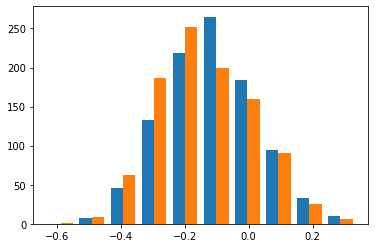

In [462]:
plt.hist(test_preds)

In [466]:
len(y_test[0])

2

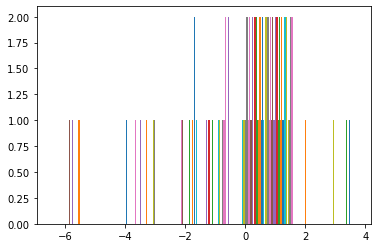

In [469]:
plt.hist(y_test,bins=5)
plt.show()

In [484]:
sklearn.metrics.mean_squared_error(np.zeros((len(y_test),2)),y_test)

1.9951304548855202

Neural Net

In [502]:
BasicNN = nn.Sequential(
    nn.Linear(len(x_train[0]),256),
    nn.ReLU(),
    nn.Linear(256,64),
#     nn.ReLU(),
#     nn.Linear(256,64),
#     nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(64,2)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(BasicNN.parameters(),lr=1e-4,weight_decay=1e-5)

epochs = 5

In [503]:
for i in range(epochs):
    print('Epoch '+str(i+1))
    for k in range(len(x_train)):
        X = torch.Tensor(x_train[k])
        y = torch.Tensor(y_train[k])
        
        optimizer.zero_grad()
        
        output = BasicNN(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        train_preds = BasicNN(torch.Tensor(x_train))
        print('Neural Net Train MSE: '+str(sklearn.metrics.mean_squared_error(train_preds,y_train)))
        val_preds = BasicNN(torch.Tensor(x_val))
        print('Neural Net Val MSE: '+str(sklearn.metrics.mean_squared_error(val_preds,y_val)))
        

Epoch 1
Neural Net Train MSE: 2.9504990180421196
Neural Net Val MSE: 3.0859418303100634
Epoch 2
Neural Net Train MSE: 1.8138591005260518
Neural Net Val MSE: 1.7815092875683702
Epoch 3
Neural Net Train MSE: 1.7993132507936989
Neural Net Val MSE: 1.7686998373586373
Epoch 4
Neural Net Train MSE: 1.7988332949066916
Neural Net Val MSE: 1.7694736915122342
Epoch 5
Neural Net Train MSE: 1.8039965291237938
Neural Net Val MSE: 1.7730353851285328


In [504]:
with torch.no_grad():
    test_preds = BasicNN(torch.Tensor(x_test))
    print('Neural Net Test MSE: '+str(sklearn.metrics.mean_squared_error(test_preds,y_test)))

Neural Net Test MSE: 1.9827804160481342
